In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import defaultdict
%matplotlib inline

In [2]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [3]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv" , low_memory=True,usecols=["user_id","anime_id","rating"])

In [4]:
rating_df

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10
...,...,...,...
6999995,22944,4214,0
6999996,22944,2000,0
6999997,22944,64,0
6999998,22944,65,0


In [5]:
n_ratings = rating_df["user_id"].value_counts()
n_ratings.describe()

count    21103.000000
mean       331.706392
std        427.421422
min          1.000000
25%         92.000000
50%        221.000000
75%        434.000000
max      17546.000000
Name: count, dtype: float64

In [6]:
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>=200].index)].copy()

In [7]:
rating_df

,user_id,anime_id,rating
213,2,24833,0
214,2,235,10
215,2,36721,0
216,2,40956,0
217,2,31933,0
...,...,...,...
6999995,22944,4214,0
6999996,22944,2000,0
6999997,22944,64,0
6999998,22944,65,0


In [8]:
min_rating=min(rating_df['rating'])
avg_rating=np.mean(rating_df['rating'])
max_rating=max(rating_df['rating'])

In [9]:
min_rating,avg_rating,max_rating

(0, np.float64(4.187716203149732), 10)

In [10]:
min_max=MinMaxScaler()

In [11]:
rating_df['rating']=min_max.fit_transform(rating_df[['rating']])

In [12]:
rating_df['rating'].value_counts()

rating
0.0    2645171
0.8     863086
0.7     815754
0.9     549953
0.6     437456
1.0     360810
0.5     237799
0.4     109123
0.3      53691
0.2      32180
0.1      25785
Name: count, dtype: int64

In [13]:
rating_df.duplicated().sum()

np.int64(0)

In [14]:
rating_df

,user_id,anime_id,rating
213,2,24833,0.0
214,2,235,1.0
215,2,36721,0.0
216,2,40956,0.0
217,2,31933,0.0
...,...,...,...
6999995,22944,4214,0.0
6999996,22944,2000,0.0
6999997,22944,64,0.0
6999998,22944,65,0.0


In [15]:
user_ids = rating_df["user_id"].unique().tolist()
user_2_user_Encoded={x:i for i,x in enumerate(user_ids)}
user_2_user_Decoded={i:x for i,x in enumerate(user_ids)}
user_ids

[2,
 3,
 6,
 11,
 12,
 16,
 17,
 19,
 21,
 25,
 33,
 34,
 36,
 38,
 41,
 42,
 44,
 46,
 47,
 49,
 52,
 53,
 55,
 60,
 61,
 64,
 65,
 66,
 67,
 71,
 72,
 73,
 74,
 78,
 80,
 81,
 82,
 83,
 84,
 85,
 89,
 90,
 94,
 98,
 101,
 102,
 108,
 110,
 111,
 112,
 113,
 117,
 119,
 120,
 121,
 122,
 124,
 126,
 127,
 129,
 131,
 135,
 136,
 138,
 145,
 146,
 147,
 148,
 153,
 154,
 155,
 156,
 157,
 158,
 160,
 163,
 164,
 166,
 172,
 173,
 174,
 181,
 184,
 185,
 188,
 190,
 191,
 193,
 194,
 195,
 196,
 197,
 198,
 202,
 204,
 205,
 209,
 211,
 214,
 215,
 219,
 222,
 224,
 227,
 228,
 229,
 235,
 237,
 238,
 240,
 243,
 246,
 248,
 251,
 252,
 254,
 257,
 259,
 262,
 264,
 265,
 266,
 267,
 269,
 272,
 274,
 275,
 280,
 281,
 283,
 284,
 285,
 286,
 288,
 290,
 291,
 293,
 294,
 296,
 300,
 301,
 304,
 306,
 308,
 310,
 311,
 313,
 314,
 316,
 320,
 321,
 322,
 324,
 325,
 326,
 327,
 330,
 331,
 332,
 336,
 340,
 341,
 342,
 345,
 346,
 347,
 349,
 350,
 351,
 357,
 358,
 359,
 360,
 363,
 36

In [16]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime_2_anime_Encoded={x:i for i,x in enumerate(anime_ids)}
anime_2_anime_Decoded={i:x for i,x in enumerate(anime_ids)}

In [17]:
# 1104 : 12 -> user2userencoded
# 12 : 1104 -> user2userDecoded

In [18]:
n_users = len(user_2_user_Encoded)
n_users

11299

In [19]:

# rating_df["user"] = le.fit_transform(rating_df["user_id"])
rating_df["user"] = rating_df["user_id"].map(user_2_user_Encoded)
rating_df["anime"] = rating_df["anime_id"].map(anime_2_anime_Encoded)
# rating_df["anime"] = le.fit_transform(rating_df["anime_id"])

In [20]:
rating_df

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4
...,...,...,...,...,...
6999995,22944,4214,0.0,11298,1325
6999996,22944,2000,0.0,11298,5704
6999997,22944,64,0.0,11298,1001
6999998,22944,65,0.0,11298,1004


In [21]:
n_anime=len(anime_2_anime_Encoded)
n_anime

17553

In [22]:
rating_df=rating_df.sample(frac=1,random_state=42).reset_index(drop=True)

In [23]:
rating_df

,user_id,anime_id,rating,user,anime
0,4654,9989,1.0,2254,513
1,3570,9465,0.0,1740,2949
2,1671,28825,0.0,827,2985
3,14726,17871,0.6,7268,7161
4,13206,5228,0.7,6478,3898
...,...,...,...,...,...
6130803,6139,34822,0.0,3007,2791
6130804,8557,6958,0.0,4201,6993
6130805,18424,12189,0.0,9129,599
6130806,16238,24,0.8,7999,9


In [24]:
X = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [25]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.01,random_state=42)

In [26]:
len(X_test)

61309

In [27]:
X_train_array = [X_train[: , 0] , X_train[: ,1]]
X_test_array = [X_test[: , 0] , X_test[: ,1]]

In [28]:
X_train_array

[array([10995,   613, 10476, ...,   851,  3350,  4785], shape=(6069499,)),
 array([600, 358, 316, ...,  81, 650, 569], shape=(6069499,))]

In [29]:
type(X_test_array[0])

numpy.ndarray

#### Model Archieture

In [30]:
def Recommend():
    embedding_Size=256

    user=Input(name='user',shape=[1])
    user_embedding = Embedding(name="user_embedding",input_dim=n_users,output_dim=embedding_Size)(user)

    anime=Input(name='anime',shape=[1])
    anime_Embedding=Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embedding_Size)(anime)

    x=Dot(normalize=True , axes=2)([user_embedding,anime_Embedding])

    x = Flatten()(x)

    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user,anime], outputs=x)
    model.compile(loss="binary_crossentropy",metrics=["mae","mse"],optimizer='Adam')
    return model

In [31]:
model = Recommend()

In [32]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 256)    │  2,892,544 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 256)    │  4,493,568 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,386,118 (28.18 MB)

 Trainable params: 7,386,116 (28.18 MB)

 Non-trainable params: 2 (8.00 B)

In [33]:
start_lr=0.0001
min_lr=0.0001
max_lr=0.01
batch_Size=10000
ramup_epochs =6
sustain_epoch=0
exp_decay = 0.7

def lr_fn(epoch): #  find  best lr for our model
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epoch:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epoch)+min_lr

In [34]:
lr_callback=LearningRateScheduler(lambda epoch:lr_fn(epoch),verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint=ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping = EarlyStopping(patience=3,monitor="val_loss",mode="min",restore_best_weights=True)

In [35]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [36]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_Size,
    epochs=20,
    verbose=1,
    validation_data = (X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20
607/607 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.6909 - mae: 0.3643 - mse: 0.1562 - val_loss: 0.6894 - val_mae: 0.3646 - val_mse: 0.1553 - learning_rate: 1.0000e-04
Epoch 2/20
607/607 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.5532 - mae: 0.2485 - mse: 0.0967 - val_loss: 0.5134 - val_mae: 0.2135 - val_mse: 0.0809 - learning_rate: 0.0018
Epoch 3/20
607/607 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.4761 - mae: 0.1887 - mse: 0.0665 - val_loss: 0.5249 - val_mae: 0.2179 - val_mse: 0.0861 - learning_rate: 0.0034
Epoch 4/20
607/607 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.4386 - mae: 0.1618 - mse: 0.0519 - val_loss: 0.5353 - val_mae: 0.2182 - val_mse: 0.0892 - learning_rate: 0.0050
Epoch 5/20
607/607 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.4181 - mae: 0.1466 - mse: 0.0438 - val_loss: 0.6311 - val_mae: 0.2545 - val_mse: 0.1206 - learning_rate: 0.0067


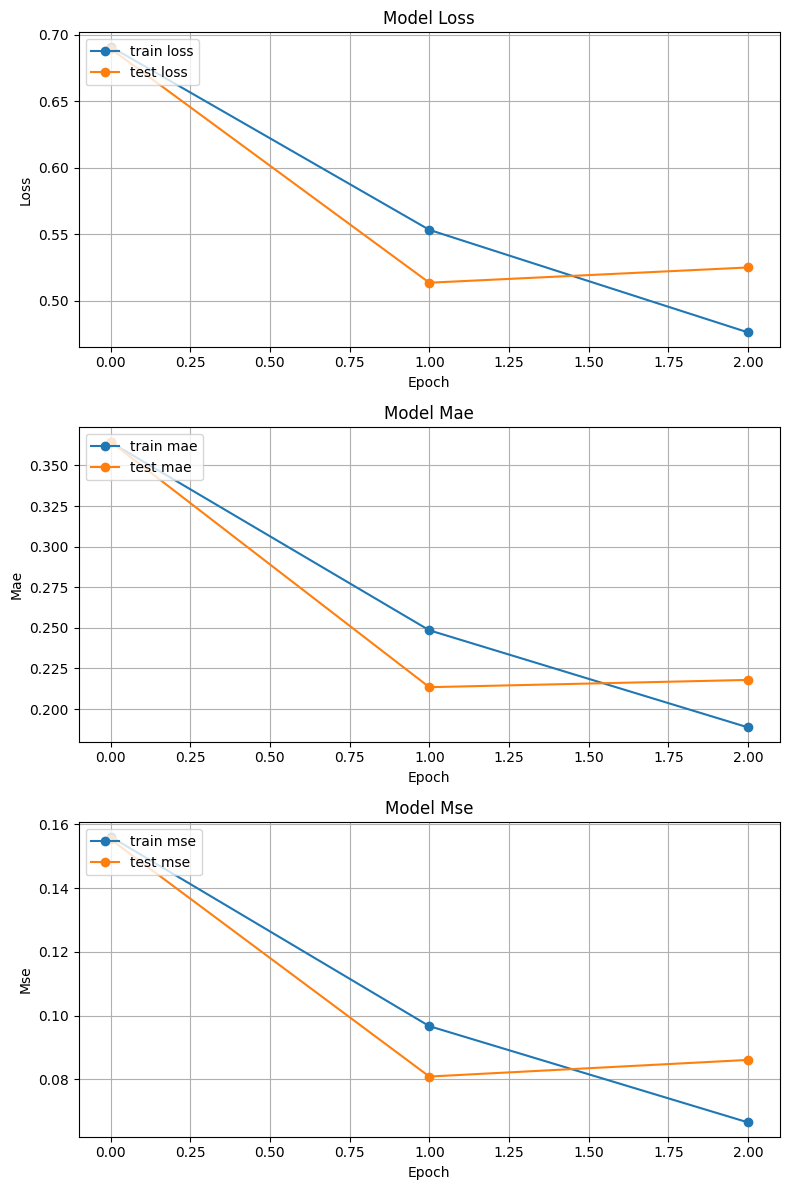

In [37]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [38]:
def extract_weights(name,model):
    weight_layer=model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [39]:
anime_Weights=extract_weights("anime_embedding",model)
user_weights=extract_weights("user_embedding",model)

#### Another dataset Anime.csv

In [40]:
anime_df = pd.read_csv(INPUT_DIR+"/anime.csv" , low_memory=True)
anime_df.T

,0,1,2,3,4,5,6,7,8,9,...,17552,17553,17554,17555,17556,17557,17558,17559,17560,17561
MAL_ID,1,5,6,7,8,15,16,17,18,19,...,48456,48466,48470,48471,48480,48481,48483,48488,48491,48492
Name,Cowboy Bebop,Cowboy Bebop: Tengoku no Tobira,Trigun,Witch Hunter Robin,Bouken Ou Beet,Eyeshield 21,Hachimitsu to Clover,Hungry Heart: Wild Striker,Initial D Fourth Stage,Monster,...,SK∞: Crazy Rock Jam,Kyoukai Senki,D_Cide Traumerei,Tsuki to Laika to Nosferatu,Wan Jie Shen Zhu 3rd Season,Daomu Biji Zhi Qinling Shen Shu,Mieruko-chan,Higurashi no Naku Koro ni Sotsu,Yama no Susume: Next Summit,Scarlet Nexus
Score,8.78,8.39,8.24,7.27,6.98,7.95,8.06,7.59,8.15,8.76,...,6.52,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
Genres,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","Action, Drama, Mystery, Sci-Fi, Space","Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Action, Mystery, Police, Supernatural, Drama, ...","Adventure, Fantasy, Shounen, Supernatural","Action, Sports, Comedy, Shounen","Comedy, Drama, Josei, Romance, Slice of Life","Slice of Life, Comedy, Sports, Shounen","Action, Cars, Sports, Drama, Seinen","Drama, Horror, Mystery, Police, Psychological,...",...,"Comedy, Sports","Action, Mecha","Action, Adventure, Drama, Magic, Fantasy","Sci-Fi, Space, Vampire","Adventure, Fantasy","Adventure, Mystery, Supernatural","Comedy, Horror, Supernatural","Mystery, Dementia, Horror, Psychological, Supe...","Adventure, Slice of Life, Comedy","Action, Fantasy"
English name,Cowboy Bebop,Cowboy Bebop:The Movie,Trigun,Witch Hunter Robin,Beet the Vandel Buster,Unknown,Honey and Clover,Unknown,Unknown,Monster,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Higurashi:When They Cry – SOTSU,Unknown,Unknown
Japanese name,カウボーイビバップ,カウボーイビバップ 天国の扉,トライガン,Witch Hunter ROBIN (ウイッチハンターロビン),冒険王ビィト,アイシールド21,ハチミツとクローバー,ハングリーハート Wild Striker,頭文字〈イニシャル〉D FOURTH STAGE,モンスター,...,SK∞ エスケーエイト #9.5 PART『クレイジーロックJAM』,境界戦機,D_CIDE TRAUMEREI（ディーサイドトロイメライ）,月とライカと吸血姫,万界神主 第三季,盗墓笔记之秦岭神树,見える子ちゃん,ひぐらしのなく頃に卒,ヤマノススメ Next Summit,SCARLET NEXUS
Type,TV,Movie,TV,TV,TV,TV,TV,TV,TV,TV,...,Special,TV,TV,TV,ONA,ONA,TV,TV,TV,TV
Episodes,26,1,26,26,52,145,24,52,24,74,...,1,Unknown,Unknown,Unknown,48,Unknown,Unknown,Unknown,Unknown,Unknown
Aired,"Apr 3, 1998 to Apr 24, 1999","Sep 1, 2001","Apr 1, 1998 to Sep 30, 1998","Jul 2, 2002 to Dec 24, 2002","Sep 30, 2004 to Sep 29, 2005","Apr 6, 2005 to Mar 19, 2008","Apr 15, 2005 to Sep 27, 2005","Sep 11, 2002 to Sep 10, 2003","Apr 17, 2004 to Feb 18, 2006","Apr 7, 2004 to Sep 28, 2005",...,"Mar 14, 2021","Oct, 2021 to ?","Jul, 2021 to ?",2021 to ?,"Mar 17, 2021 to ?","Apr 4, 2021 to ?",2021 to ?,"Jul, 2021 to ?",Unknown,"Jul, 2021 to ?"
Premiered,Spring 1998,Unknown,Spring 1998,Summer 2002,Fall 2004,Spring 2005,Spring 2005,Fall 2002,Spring 2004,Spring 2004,...,Unknown,Fall 2021,Summer 2021,Unknown,Unknown,Unknown,Unknown,Summer 2021,Unknown,Summer 2021


In [41]:
df = anime_df.replace("Unknown",np.nan)

In [42]:
df.isna().sum()

MAL_ID               0
Name                 0
Score             5141
Genres              63
English name     10565
Japanese name       48
Type                37
Episodes           516
Aired              309
Premiered        12817
Producers         7794
Licensors        13616
Studios           7079
Source            3567
Duration           555
Rating             688
Ranked            1762
Popularity           0
Members              0
Favorites            0
Watching             0
Completed            0
On-Hold              0
Dropped              0
Plan to Watch        0
Score-10           437
Score-9           3167
Score-8           1371
Score-7            503
Score-6            511
Score-5            584
Score-4            977
Score-3           1307
Score-2           1597
Score-1            459
dtype: int64

In [43]:
# fetch name of anime 1-> english name if not available then name
def anime_name(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]

    except:
         print("Error")
    
    return name        

In [44]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:anime_name(x))

In [45]:
df

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,NaN,"Adventure, Mystery, Supernatural",NaN,盗墓笔记之秦岭神树,ONA,NaN,"Apr 4, 2021 to ?",NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,48481,Daomu Biji Zhi Qinling Shen Shu
17558,48483,Mieruko-chan,NaN,"Comedy, Horror, Supernatural",NaN,見える子ちゃん,TV,NaN,2021 to ?,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48483,Mieruko-chan
17559,48488,Higurashi no Naku Koro ni Sotsu,NaN,"Mystery, Dementia, Horror, Psychological, Supe...",Higurashi:When They Cry – SOTSU,ひぐらしのなく頃に卒,TV,NaN,"Jul, 2021 to ?",Summer 2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48488,Higurashi:When They Cry – SOTSU
17560,48491,Yama no Susume: Next Summit,NaN,"Adventure, Slice of Life, Comedy",NaN,ヤマノススメ Next Summit,TV,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48491,Yama no Susume: Next Summit


In [46]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")

In [47]:
df

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,NaN,"Adventure, Mystery, Supernatural",NaN,盗墓笔记之秦岭神树,ONA,NaN,"Apr 4, 2021 to ?",NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,48481,Daomu Biji Zhi Qinling Shen Shu
17558,48483,Mieruko-chan,NaN,"Comedy, Horror, Supernatural",NaN,見える子ちゃん,TV,NaN,2021 to ?,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48483,Mieruko-chan
17559,48488,Higurashi no Naku Koro ni Sotsu,NaN,"Mystery, Dementia, Horror, Psychological, Supe...",Higurashi:When They Cry – SOTSU,ひぐらしのなく頃に卒,TV,NaN,"Jul, 2021 to ?",Summer 2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48488,Higurashi:When They Cry – SOTSU
17560,48491,Yama no Susume: Next Summit,NaN,"Adventure, Slice of Life, Comedy",NaN,ヤマノススメ Next Summit,TV,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48491,Yama no Susume: Next Summit


In [48]:
df = df[["anime_id" , "eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [49]:
df

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121
...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,NaN,"Adventure, Mystery, Supernatural",NaN,ONA,NaN,354
17558,48483,Mieruko-chan,NaN,"Comedy, Horror, Supernatural",NaN,TV,NaN,7010
17559,48488,Higurashi:When They Cry – SOTSU,NaN,"Mystery, Dementia, Horror, Psychological, Supe...",NaN,TV,Summer 2021,11309
17560,48491,Yama no Susume: Next Summit,NaN,"Adventure, Slice of Life, Comedy",NaN,TV,NaN,1386


In [50]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df['anime_id']==anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]

In [51]:
getAnimeFrame(40028 , df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [52]:
getAnimeFrame("Steins;Gate",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


#### ANIME_WITH_SYNOPSIS.CSV

In [53]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [54]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols)

synopsis_df['sypnopsis'] = synopsis_df['sypnopsis'].str.capitalize()

In [55]:
synopsis_df

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","Other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",Ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...
...,...,...,...,...
16209,48481,Daomu Biji Zhi Qinling Shen Shu,"Adventure, Mystery, Supernatural",No synopsis information has been added to this...
16210,48483,Mieruko-chan,"Comedy, Horror, Supernatural",Ko is a typical high school student whose life...
16211,48488,Higurashi no Naku Koro ni Sotsu,"Mystery, Dementia, Horror, Psychological, Supe...",Sequel to higurashi no naku koro ni gou .
16212,48491,Yama no Susume: Next Summit,"Adventure, Slice of Life, Comedy",New yama no susume anime.


In [56]:
synopsis_df["anime_id"] = synopsis_df["MAL_ID"]

In [57]:
def getsynopsis(anime,df):
    if isinstance(anime,int):
        return df[df['anime_id']==anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return df[df.Name == anime].sypnopsis.values[0]

In [58]:
getsynopsis(40028 , synopsis_df)

"Gabi braun and falco grice have been training their entire lives to inherit one of the seven titans under marley's control and aid their nation in eradicating the eldians on paradis. however, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of eren yeager and the remaining members of the survey corps. having finally reached the yeager family basement and learned about the dark history surrounding the titans, the survey corps has at long last found the answer they so desperately fought to uncover. with the truth now in their hands, the group set out for the world beyond the walls. in shingeki no kyojin: the final season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to paradis' fight for freedom."

In [59]:
getsynopsis("Steins;Gate",synopsis_df)

'The self-proclaimed mad scientist rintarou okabe rents out a room in a rickety old building in akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: mayuri shiina, his air-headed childhood friend, and hashida itaru, a perverted hacker nicknamed "daru." the three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "phone microwave," which performs the strange function of morphing bananas into piles of green gel. though miraculous in itself, the phenomenon doesn\'t provide anything concrete in okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the phone microwave can send emails to the past, altering the flow of history. adapted from the critically acclaimed visual novel by 5pb. and nitroplus, steins;gate takes okabe through the depths of scientific theory 

## Content Based 

In [163]:
def item_based_recommnedation_system(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    try:
        index = getAnimeFrame(name,df).anime_id.values[0]
        encoded_index=anime2anime_encoded.get(index)

        weights=anime_weights

        dist=np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dist)

        n=n+1
        if neg: # will fetch dismiar animes
            closest=sorted_dists[:n]
            print(f'Dissimilar anime to {name}')

        else: # this will fetch similar animes
            closest = sorted_dists[-n:] 

            print(f'Similar anime to {name}')

        if return_dist:
            return dist,closest             
    
        similarlityArr=[]
        for close in closest:
            decoded_id=anime2anime_decoded.get(close)

            # synopsis=getsynopsis(decoded_id,synopsis_df)

            anime_frame=getAnimeFrame(decoded_id,df)

            anime_name=anime_frame.eng_version.values[0]
            genre=anime_frame.Genres.values[0]
            score=anime_frame.Score.values[0]
            similarity = dist[close]

            similarlityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
            'Score':score,
            # 'synopsis':synopsis,
            })


        Frame=pd.DataFrame(similarlityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id!=index].drop(['anime_id'], axis=1)
    
    except Exception as e:
        print("Error Occured",e)

In [164]:
item_based_recommnedation_system(
    "Attack on Titan",
    anime_Weights,
    anime_2_anime_Encoded,
    anime_2_anime_Decoded,
    df,
    synopsis_df,
    n=5

)

Similar anime to Attack on Titan


,name,similarity,genre,Score
4,Death Note,0.910060,"Mystery, Police, Psychological, Supernatural, ...",8.63
3,One Punch Man,0.881470,"Action, Sci-Fi, Comedy, Parody, Super Power, S...",8.57
2,My Hero Academia,0.849414,"Action, Comedy, School, Shounen, Super Power",8.11
1,Your Name.,0.849414,"Romance, Supernatural, School, Drama",8.96
0,Code Geass:Lelouch of the Rebellion R2,0.820599,"Action, Military, Sci-Fi, Super Power, Drama, ...",8.91


## User Based Collabrative 

Find Similar users

In [165]:
def find_similar_users(item_input , user_weights , user2user_encoded , user2user_decoded, n=10 , return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index=user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
            
        else:
            closest = sorted_dists[-n:]

        if return_dist:
            return dists,closest             
    
        SimilarityArr=[]    
        for close in closest:
            similarity = dists[close] 
            if isinstance(item_input,int):
                decoded_idx=user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_idx,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users   

    except Exception as e:
        print("Error Occured",e)    

In [166]:
find_similar_users(int(11800),user_weights,user_2_user_Encoded,user_2_user_Decoded)

,similar_users,similarity
9,18483,0.412941
8,10497,0.408360
7,20228,0.403936
6,14635,0.376058
5,16934,0.362750
4,5316,0.362322
3,9673,0.351492
2,15288,0.349704
1,12770,0.347309
0,240,0.343834


In [167]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='gray',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,12))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [168]:
def getFavGenre(frame,plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list

In [169]:
df.head(3)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


In [170]:
x=getAnimeFrame(1,df)
x

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26,TV,Spring 1998,1251960


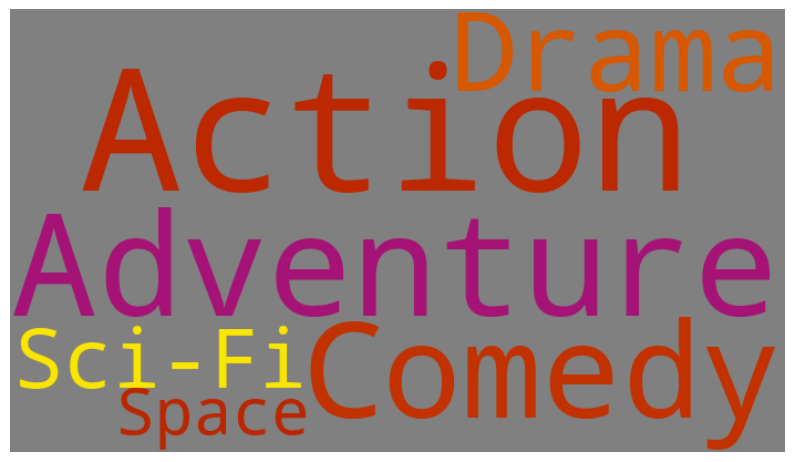

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [171]:
getFavGenre(x,plot=True)

In [172]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,4654,9989,1.0,2254,513
1,3570,9465,0.0,1740,2949


In [173]:
# extract user perfences

def get_user_preferences(user_id , rating_df , df ,plot=False):
    animes_watched_by_user = rating_df[rating_df.user_id==user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating,70)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating>=user_rating_percentile]
    top_anime_user=(
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values
    )

    anime_df_Rows=df[df['anime_id'].isin(top_anime_user)]
    anime_df_Rows=anime_df_Rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_Rows,plot)

    return anime_df_Rows

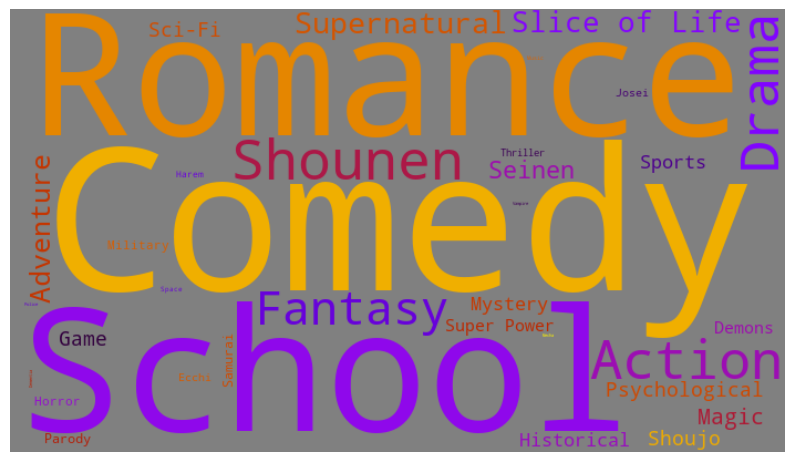

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma..."
14963,Attack on Titan Season 3 Part 2,"Action, Drama, Fantasy, Military, Mystery, Sho..."
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, S..."
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Sa..."
...,...,...
12336,Gamers!,"Game, Comedy, Romance, School"
12706,Love and Lies,"Drama, Romance, School"
15086,7 Seeds,"Adventure, Drama, Mystery, Psychological, Roma..."
15759,The Seven Deadly Sins:Wrath of the Gods,"Action, Adventure, Supernatural, Magic, Fantas..."


In [174]:
get_user_preferences(int(11800) , rating_df, df , plot=True)

#### User Based

In [175]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):
    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        # gettting user preference of similar users
        pref_list=get_user_preferences(int(user_id),rating_df,df)
        # exclude already rated names from this prefences
        pref_list=pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
        anime_list = pd.DataFrame(anime_list)    
        # we have got top n anime in this sorted list
        sorted_list=pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)
        # print(sorted_list)

        for i , anime_name in enumerate(sorted_list.index):
            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

            # if anime name is in string
            if isinstance(anime_name,str):
                frame=getAnimeFrame(anime_name,df)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                score=frame.Score.values[0]
                synopsis = getsynopsis(int(anime_id),synopsis_df)

                recommended_animes.append({
                    "No_of_user_prefences" : n_user_pref,
                    'Scores': score,
                    "anime_name" : anime_name,
                    "Genres" : genre,
                    "Synopsis": synopsis
                })
    return pd.DataFrame(recommended_animes).head(n)

# def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

#     recommended_animes = []
#     anime_list = []

#     for user_id in similar_users.similar_users.values:
#         pref_list = get_user_preferences(int(user_id) , rating_df, df)

#         pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

#         if not pref_list.empty:
#             anime_list.append(pref_list.eng_version.values)

#     if anime_list:
#             anime_list = pd.DataFrame(anime_list)

#             sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

#             for i,anime_name in enumerate(sorted_list.index):
#                 n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

#                 if isinstance(anime_name,str):
#                     frame = getAnimeFrame(anime_name,df)
#                     anime_id = frame.anime_id.values[0]
#                     genre = frame.Genres.values[0]
#                     synopsis = getsynopsis(int(anime_id),synopsis_df)

#                     recommended_animes.append({
#                         "No_of_user_prefences" : n_user_pref,
#                         "anime_name" : anime_name,
#                         "Genres" : genre,
#                         "Synopsis": synopsis
#                     })
#     return pd.DataFrame(recommended_animes).head(n)

In [176]:
similar_users =find_similar_users(int(11880),user_weights,user_2_user_Encoded,user_2_user_Decoded)
similar_users

,similar_users,similarity
9,19766,0.502835
8,22254,0.482737
7,12577,0.481696
6,7287,0.479240
5,2157,0.471519
4,16824,0.469008
3,15781,0.464055
2,10026,0.462404
1,17918,0.461028
0,17178,0.460675


In [177]:
user_pref = get_user_preferences(11880 , rating_df, df , plot=False)
user_pref

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma..."
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, S..."
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Sa..."
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [178]:
get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)

,No_of_user_prefences,Scores,anime_name,Genres,Synopsis
0,9,9.11,Steins;Gate,"Thriller, Sci-Fi",The self-proclaimed mad scientist rintarou oka...
1,8,8.42,anohana:The Flower We Saw That Day,"Slice of Life, Supernatural, Drama",Jinta yadomi is peacefully living as a recluse...
2,8,8.96,Clannad ~After Story~,"Slice of Life, Comedy, Supernatural, Drama, Ro...","Clannad: after story , the sequel to the criti..."
3,8,8.15,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",Otonashi awakens only to learn he is dead. a r...
4,8,8.48,Attack on Titan,"Action, Military, Mystery, Super Power, Drama,...","Centuries ago, mankind was slaughtered to near..."
5,8,8.24,Toradora!,"Slice of Life, Comedy, Romance, School",Uuji takasu is a gentle high school student wi...
6,8,7.25,Sword Art Online,"Action, Game, Adventure, Romance, Fantasy","In the year 2022, virtual reality has progress..."
7,7,8.72,Code Geass:Lelouch of the Rebellion,"Action, Military, Sci-Fi, Super Power, Drama, ...","In the year 2010, the holy empire of britannia..."
8,7,8.64,Wolf Children,"Fantasy, Slice of Life","Hana, a hard-working college student, falls in..."
9,7,8.2,The Girl Who Leapt Through Time,"Adventure, Drama, Romance, Sci-Fi",Akoto konno is in her last year of high school...


## Hybrid System

In [ ]:
def hybrid_recommendation(user_id , user_weight=0.4, content_weight =0.6):
     ## User Recommndation
     similar_users =find_similar_users(user_id,user_weights,user_2_user_Encoded,user_2_user_Decoded)
     user_pref = get_user_preferences(user_id , rating_df, df)
     user_recommended_animes =get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)

     user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
     print(user_recommended_anime_list)

     ## Content recommendation
     content_recommendation_animes=[]
     for anime in user_recommended_anime_list:
          similar_animes = find_similar_users(anime, anime_Weights, anime_2_anime_Encoded, anime_2_anime_Decoded)
          if similar_animes is not None and not similar_animes.empty:
               content_recommendation_animes.extend(similar_animes['name'].tolist())
               
          else:
            print(f"No similar anime found {anime}")
          
     # combing scores   
     combined_scores = {}   

     for anime in user_recommended_anime_list:
         combined_scores[anime]= combined_scores.get(anime,0) + user_weight

     for anime in content_recommendation_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight


     sorted_animes=sorted(combined_scores.items(),key=lambda x:x[1], reverse=True)

     return [anime for anime , score in sorted_animes[:10]] 

     


In [196]:
hybrid_recommendation(13394)

['Nisekoi:False Love', 'GATE', 'Trinity Seven', 'Tokyo Ghoul', 'One Punch Man', 'Tokyo Ghoul √A', 'Log Horizon', 'Food Wars! Shokugeki no Soma', 'BTOOOM!', 'The Devil is a Part-Timer!']
Error Occured shapes (17553,256) and (1,17553,256) not aligned: 256 (dim 1) != 17553 (dim 1)
No similar anime found Nisekoi:False Love
Error Occured shapes (17553,256) and (1,17553,256) not aligned: 256 (dim 1) != 17553 (dim 1)
No similar anime found GATE
Error Occured shapes (17553,256) and (1,17553,256) not aligned: 256 (dim 1) != 17553 (dim 1)
No similar anime found Trinity Seven
Error Occured shapes (17553,256) and (1,17553,256) not aligned: 256 (dim 1) != 17553 (dim 1)
No similar anime found Tokyo Ghoul
Error Occured shapes (17553,256) and (1,17553,256) not aligned: 256 (dim 1) != 17553 (dim 1)
No similar anime found One Punch Man
Error Occured shapes (17553,256) and (1,17553,256) not aligned: 256 (dim 1) != 17553 (dim 1)
No similar anime found Tokyo Ghoul √A
Error Occured shapes (17553,256) and (1

['Nisekoi:False Love',
 'GATE',
 'Trinity Seven',
 'Tokyo Ghoul',
 'One Punch Man',
 'Tokyo Ghoul √A',
 'Log Horizon',
 'Food Wars! Shokugeki no Soma',
 'BTOOOM!',
 'The Devil is a Part-Timer!']